In [1]:
import pandas as pd
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Your dataset path
csv_path = "clean_ds/both_serv.csv"
# csv_path = "clean_ds/only_int.csv"
# csv_path = "clean_ds/only_ph.csv"

# Load dataset
df = pd.read_csv(csv_path)

# Extract the base filename without extension
dataset_name = os.path.splitext(os.path.basename(csv_path))[0]
time_cap = datetime.now().strftime('%Y%m%d_%H%M%S')
folder_name = f"models/nn/{time_cap}"
os.makedirs(folder_name, exist_ok=True)

In [3]:
# Separate features (X) and target label (y)
X = df.drop(columns='Churn')
y = df['Churn']

In [4]:
# 80% training, 20% testing
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [5]:
# Only scale numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()

# Fit only on training data
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [6]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using {device}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)


# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


Device using cuda


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [127]:
class ChurnNN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = ChurnNN(input_dim=X_train.shape[1]).to(device)

learning_rate = 0.0005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [128]:
train_accuracies = []
val_accuracies = []
val_losses = []
epoch_logs = []

epoch = 80

for epoch in range(epoch):
    model.train()
    start_time = time.time()
    total_loss = 0

    # Training step
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate on training set
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor).cpu().numpy()
        train_preds = (train_preds >= 0.5).astype(int)
        train_labels = y_train_tensor.cpu().numpy()
        train_acc = accuracy_score(train_labels, train_preds)

        # Evaluate on validation set
        val_preds = model(X_val_tensor).cpu().numpy()
        val_preds = (val_preds >= 0.5).astype(int)
        val_labels = y_val_tensor.cpu().numpy()
        val_acc = accuracy_score(val_labels, val_preds)

        # Optional: calculate val loss
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor).item()

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    epoch_logs.append({
        "epoch": epoch + 1,
        "train_loss": round(total_loss, 4),
        "train_acc": round(train_acc, 4),
        "val_loss": round(val_loss, 4),
        "val_acc": round(val_acc, 4),
        "time": round(epoch_time, 2)
    })

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {epoch_time:.2f}s")


Epoch 01 | Train Loss: 118.8737 | Train Acc: 0.6717 | Val Loss: 0.5723 | Val Acc: 0.6714 | Time: 0.34s
Epoch 02 | Train Loss: 105.5250 | Train Acc: 0.7280 | Val Loss: 0.5211 | Val Acc: 0.7193 | Time: 0.27s
Epoch 03 | Train Loss: 99.0205 | Train Acc: 0.7510 | Val Loss: 0.5057 | Val Acc: 0.7451 | Time: 0.26s
Epoch 04 | Train Loss: 97.0925 | Train Acc: 0.7552 | Val Loss: 0.5021 | Val Acc: 0.7464 | Time: 0.26s
Epoch 05 | Train Loss: 96.0326 | Train Acc: 0.7552 | Val Loss: 0.4987 | Val Acc: 0.7400 | Time: 0.26s
Epoch 06 | Train Loss: 95.2759 | Train Acc: 0.7565 | Val Loss: 0.4977 | Val Acc: 0.7490 | Time: 0.25s
Epoch 07 | Train Loss: 94.6317 | Train Acc: 0.7565 | Val Loss: 0.4974 | Val Acc: 0.7464 | Time: 0.25s
Epoch 08 | Train Loss: 94.6675 | Train Acc: 0.7571 | Val Loss: 0.4979 | Val Acc: 0.7439 | Time: 0.25s
Epoch 09 | Train Loss: 94.0391 | Train Acc: 0.7561 | Val Loss: 0.4995 | Val Acc: 0.7361 | Time: 0.25s
Epoch 10 | Train Loss: 94.2618 | Train Acc: 0.7600 | Val Loss: 0.5018 | Val Acc:

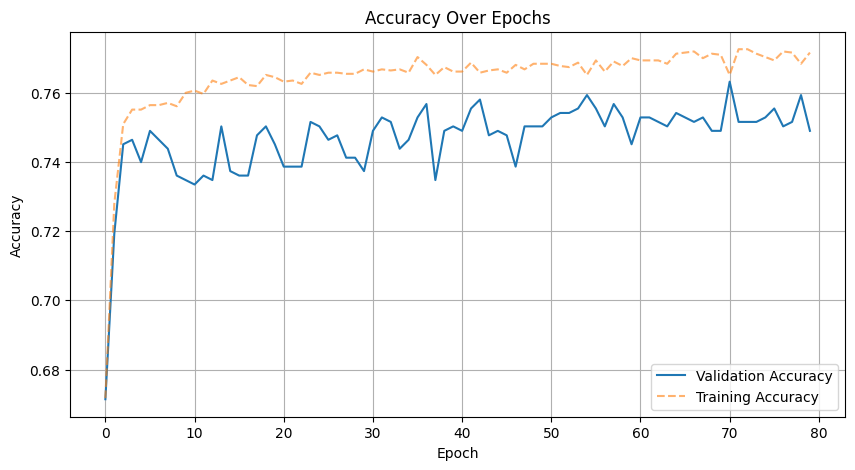

In [129]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(train_accuracies, label='Training Accuracy', linestyle='--', alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig(f"{folder_name}/{time_cap}_{dataset_name}_valacc_curve.png")
plt.show()

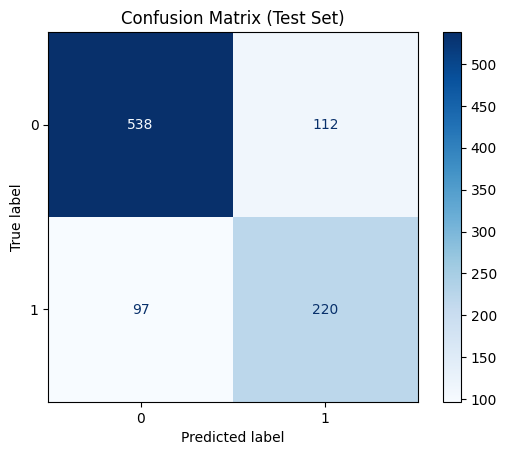

ROC AUC value: 0.8389808298956565


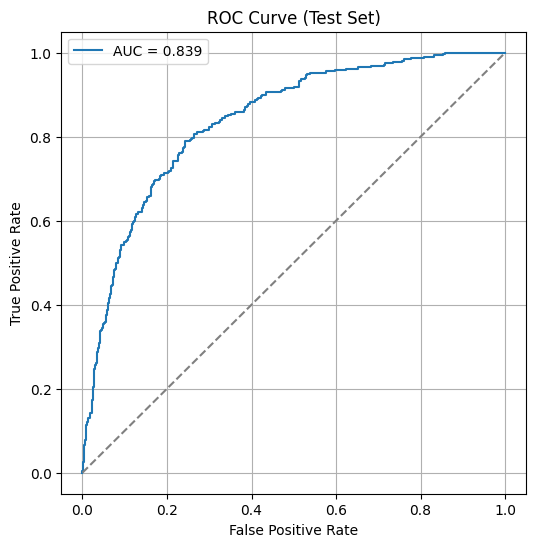

: 

In [ ]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_probs = model(X_test_tensor).cpu().numpy().flatten()
    test_preds = (test_probs >= 0.5).astype(int)
    test_labels = y_test_tensor.cpu().numpy().flatten()

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.savefig(f"{folder_name}/{time_cap}_{dataset_name}_conf_matrix.png")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(test_labels, test_probs)
fpr, tpr, _ = roc_curve(test_labels, test_probs)
report = classification_report(test_labels, test_preds, output_dict=True)
print(f"ROC AUC value: {roc_auc}")
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.savefig(f"{folder_name}/{time_cap}_{dataset_name}_roc_curve.png")
plt.show()

# Log object
log_data = {
    "timestamp": datetime.now().isoformat(),
    "model": "Neural Network",
    "architecture": str(model),
    "learning_rate": learning_rate,
    "loss_function": criterion.__class__.__name__,
    "optimizer": optimizer.__class__.__name__,
    "epoch": epoch + 1,
    "roc_auc": roc_auc,
    "classification_report": report,
    "plots": {
        "roc_curve": f"{time_cap}_{dataset_name}_roc_curve.png",
        "confusion_matrix": f"{time_cap}_{dataset_name}_conf_matrix.png",
        "vaidation_acc_graph": f"{time_cap}_{dataset_name}_valacc_curve.png"
    },
    "epoch_logs": epoch_logs,
}

# Save to JSON
filename = f"{folder_name}/{time_cap}_{dataset_name}_nn_log_v1.json"
with open(filename, "w") as f:
    json.dump(log_data, f, indent=4)